Laidin Tino, Université de Nantes, July 2021

# Kinetic/Fluid coupling in diffusion limit

## Vlasov
We are interested in the following transport equation 
$$\partial_t f^\varepsilon + \frac{1}{\varepsilon}(v\partial_x f^\varepsilon+E\partial_v f^\varepsilon) = \frac{1}{\varepsilon^2}\left(\rho^\epsilon\mathcal{M}(v) - f^\varepsilon\right)\,,\qquad \rho^\varepsilon(t,x)\ =\ \int f^\varepsilon(t,x,v)\,\mathrm{d}v$$

where $\mathcal{M}(v)=\frac{1}{\sqrt{2\pi}}e^{\frac{-v^2}{2}}$ is a gaussian Maxwellian distribution and $E$ is a given exterior electrical field.

### Chapmann-Enskog
We decompose $f$ as
$$f=\rho\mathcal{M} + \varepsilon g^{(1)}+ \varepsilon^2 g^{(2)}+ \varepsilon^3 g^{(3)} + \dots $$

In [1]:
%matplotlib inline
from FV_solvers_Efield import *

In [2]:
name = "BGK-EF"

### Velocity discretization

The velocity domain is a bounded symmetric segment $[-v_{\star},v_{\star}]$. 
We consider a primal mesh of this interval composed of $N_v = 2L$ control volumes arranged symmetrically around $v = 0$. We thus get $2L+1$ distinct interface points denoted by $v_{j+\frac{1}{2}}$. In this way $v_{-L+1/2} = -v_{\star}$, $v_{1/2} = 0$ and $v_{j+1/2} = -v_{-j+1/2}$. Each cell has length $\Delta v_{j}=v_{j+\frac{1}{2}}-v_{j-\frac{1}{2}}$ and midpoint $v_j$.

In [3]:
vstar = 8.0 #Right endpoint
L = 32 #Number of positive velocity cells
(v,vhalf,dv,Nv,vmin,vmax) = discretizeV(L,vstar)

### Space discretization
In space, we consider a discretization of the torus $\mathbb{T}_{x_\star} = \mathbb{R}/x_\star\mathbb{Z}$ into $N_x$ subintervals of length $\Delta x_{i}$ and centers $x_{i}$.

In [4]:
xstar = np.pi #Length of the domain
Nx = 3**3 #Number of cells
(x,xhalf,dx,invdx,Nx,xmin,xmax) = discretizeX(Nx,xstar)

### Phase space discretization

In [5]:
(X,V,DV,invDV,DX,invDX,N) = discretizeXV(x,Nx,dx,invdx,v,Nv,dv)

## Discrete Maxwellian

In [6]:
dist = gaussian
    
(M,Mhalf,MM) = Maxwellian(dist, v, vhalf, dv,Nx)
m0 = Maxw_moment(M,0,v,dv)
m2 = Maxw_moment(M,2,v,dv)
m4 = Maxw_moment(M,4,v,dv)
print("0th moment :", m0)
print("2nd moment :", m2)
print("4th moment :", m4)

0th moment : 0.9999999999999999
2nd moment : 0.9999999999999307
4th moment : 2.9999999999953193


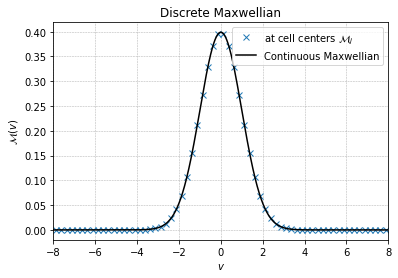

In [7]:
plt.rcParams['figure.figsize'] = 6, 4
plt.figure
plt.xlabel(r'$v$')
plt.ylabel(r'$\mathcal{M}(v)$')
plt.xlim([vmin, vmax])

vplot = np.linspace(vmin,vmax,1000)

Mplot = dist(vplot)
Mass = np.sum(Mplot)*(vplot[2]-vplot[1])
Mplot = Mplot/Mass
plt.plot(v, M, label = 'at cell centers $\mathcal{M}_{j}$', marker = 'x', ls = 'None')
plt.plot(vplot, Mplot, label = "Continuous Maxwellian", color = 'black')
plt.title("Discrete Maxwellian")
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Exterior elecrical field

In [8]:
E_field = 1

if E_field == 1:
    (E, dxE, intE) = E_Cosinus(X,xstar)
    Etest = "Cos"
else:
    (E, dxE,intE) = E_Null(X)
    Etest = "Null"

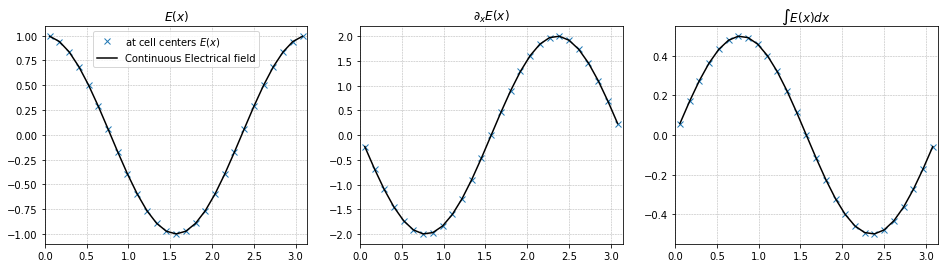

In [9]:
plt.rcParams['figure.figsize'] = 16, 4
plt.figure
plt.title("Exterior electrical field")
plt.xlabel(r'$x$')

plt.subplot(1,3,1)
plt.plot(x, E[0,:], label = 'at cell centers $E(x)$', marker = 'x', ls = 'None')
plt.plot(x, E[0,:], label = "Continuous Electrical field", color = 'black')
plt.title(r'$E(x)$')
plt.xlim([0, xstar])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1,3,2)
plt.plot(x, dxE[0,:], label = 'at cell centers $\partial_xE(x)$', marker = 'x', ls = 'None')
plt.plot(x, dxE[0,:], label = "Continuous Electrical field", color = 'black')
plt.title(r'$\partial_xE(x)$')
plt.xlim([0, xstar])
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(1,3,3)
plt.plot(x, intE[0,:], label = 'at cell centers $\int E(x) dx$', marker = 'x', ls = 'None')
plt.plot(x, intE[0,:], label = "Continuous Electrical field", color = 'black')
plt.title(r'$\int E(x) dx$')
plt.xlim([0, xstar])
plt.grid(linestyle='--', linewidth=0.5)

plt.show()

## Initial data and equilibrium

### Initial data

In [10]:
def init_custom(X,V,xstar):
    """ Brief: debug initial condition 
    Input:
        - X,V: phase space discretisation (meshgrid form)
    Output:
        - F: Initial data (meshgrid form)
    """
    
    F = gaussian(V-4.0)*gaussian((X-np.pi/2)/0.3) + gaussian(V)*gaussian((X-np.pi/2)/0.3) 
    F += gaussian(V+4.0)*gaussian((X-np.pi/2)/0.3) + 0.1*gaussian(V)*V**4*(1+1*np.cos(2 * np.pi * X / xstar))

    return F

In [11]:
init_data = 0

if init_data == 1:
    F = init_Gaussian(X,V,xstar)
    test = "Gaussian"
elif init_data == 2:
    F = init_Oscillation(X,V,xstar)
    test = "Oscillation"
elif init_data == 3:
    F = init_other(X,V,xstar)
    test = "Other"
else:
    F = init_custom(X,V,xstar)
    test = "Custom"

### Equilibrium
Global continuous equilibrium: if $E=-\partial_x V$, 
$$\mathcal{E}(x,v) = \frac{1}{\mu_0}e^{-(V(x)+\frac{v^2}{2})},\quad\mbox{ avec }\quad \mu_0=\int e^{-(V(x)+\frac{v^2}{2})}\,\mathrm{d}x\,\mathrm{d}v.$$

In [12]:
(Finf,mf) = Equilibrium(F,MM,E,intE,DX,DV,xstar)
(Rho0,G0) = initAll(F, Finf, MM, DV, mf)

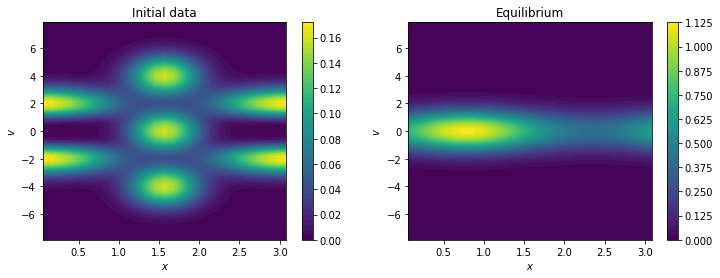

In [13]:
plt.rcParams['figure.figsize'] = 12, 4

plt.subplot(1,2,1)
plt.contourf(X,V,F, 50,cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Initial data')
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')

plt.subplot(1,2,2)
plt.contourf(X,V,Finf, 50,cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Equilibrium')
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
plt.show()

### Numerical scheme


We use a finite volume scheme with centered fluxes and a forward Euler scheme in time.

$$\frac{f_{ij}^{n+1}-f_{ij}^{n}}{\Delta t}=-\frac{1}{\varepsilon\Delta x_i\Delta v_j}\left( (\mathcal{F}_{i+\frac{1}{2},j}(f)-\mathcal{F}_{i-\frac{1}{2},j}(f)\right) + \left(\mathcal{G}_{i,j+\frac{1}{2}}(f)-\mathcal{G}_{i,j-\frac{1}{2}}(f)\right) + \frac{1}{\varepsilon^2}(\rho_iM_j-f_{ij}) $$
where
\begin{equation}
    \left\lbrace\begin{aligned}
    \mathcal{F}_{i+\frac{1}{2},j}(f) &= \frac{1}{2}(f_{ij}+f_{i+1,j})v_j\Delta v_j\\
    \mathcal{G}_{i,j+\frac{1}{2}}(f) &= \frac{1}{2}(f_{ij}+f_{i,j+1})E_i\Delta x_i\\
    \end{aligned}\right.
\end{equation}

### Time discretization
The stability conditions implies that 
$$ \Delta t\leq2C\min\left\lbrace\frac{\Delta x^2}{m_2^{\Delta v}},\frac{\Delta x}{E_{max}}\right\rbrace,$$ 
where $E_{max}=\underset{x\in\mathbb{T}}{\max} E(x)$.
for the limit scheme and 
$$\Delta t\leq C\min\left\lbrace\frac{\varepsilon\Delta x}{v^\star},\frac{\varepsilon\Delta v}{E_{max}},\varepsilon^2\right\rbrace $$
for the finite volume one. Therefore, we take $\Delta t$ such that both condition are fulfilled.

### Time loop

In [14]:
# Knudsen number
epsilon = 0.8

# Time step and final time
C = 0.05
(dt,dtLim,dtFV) = CFL(np.max(dx),np.max(dv),m2,np.max(E),vstar,epsilon,C)
T = 5.0
# dt=dtLim

print('|---------------------------------------------------------')
print('| Time steps :')
print('| FV    : ', dtFV)
print('| Limit : ', dtLim)
print('| Used  : ', dt)
print('| Final time  : ', T)
print('|------------------')

i = 0
t = [0]
inveps = 1.0/epsilon

# Initialize unknows
Fn     = F
rho    = np.sum(F*DV, axis=0)
fluid  = rho

F_    = [Fn.copy()]
rho_  = [rho.copy()] 
fluid_= [fluid.copy()]

(indKinetic, indFluid) = indicators(rho, fluid, E[0,:], dxE[0,:], invdx)
indKinetic_, indFluid_ = [indKinetic], [indFluid]
L1G_ = [np.sum(np.abs(G0*DV),axis=0)]

start = time.time()
while t[-1] < T: # and i<1:
    # Update Micro-Macro unknowns and f
    Fn = solve_Kinetic(Fn, E, MM, invDX, V, DV, invDV, dt, m2, inveps)

    # Update the diffusion limit (heat equation)
    rho = solve_Fluid(rho, E[0,:], m2, invdx, dt)
    
    # Save unknowns
    t.append(t[-1] + dt)
    F_.append(Fn.copy())
    rho_.append(np.sum(Fn*DV, axis=0).copy())
    fluid_.append(rho.copy())
    
    (indKinetic, indFluid) = indicators(np.sum(Fn*DV, axis=0), rho, E[0,:], dxE[0,:], invdx)
    indKinetic_.append(indKinetic)
    indFluid_.append(indFluid)
    L1G_.append(np.sum(DV*np.abs(Fn - np.tile(rho.T,(Nv,1))*MM), axis=0))
    
    # Increment
    i = i + 1
stop = time.time()

m, s = divmod(stop-start, 60)
h, m = divmod(m, 60)
print("| Elapsed time: "+'{:f}:{:02f}:{:02f}'.format(h, m, s))
print('|---------------------------------------------------------')

|---------------------------------------------------------
| Time steps :
| FV    :  0.0005817764173314433
| Limit :  0.0013538551990521326
| Used  :  0.0005817764173314433
| Final time  :  5.0
|------------------
| Elapsed time: 0.000000:0.000000:1.997416
|---------------------------------------------------------


### Snapshots pf the distribution

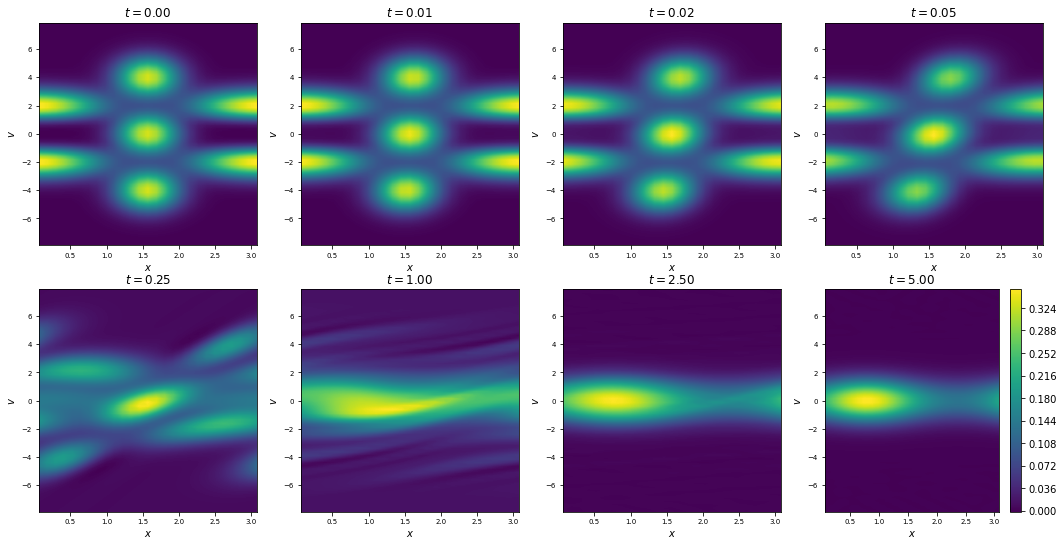

In [15]:
Nt = len(t)
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//20, len(t)//5, len(t)//2, len(t)-1]
plt.rcParams['figure.figsize'] = 18, 9
for i in range(2):
    for j in range(4):
        index = i + j*2
        plt.subplot(2,4,1+i + j*2)
        plt.contourf(X,V,F_[time_indices[index]], 500, cmap=plt.cm.viridis)
        plt.title(r'$t = $'+('%.2f' % t[time_indices[index]]))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$v$')
        plt.tick_params(axis='both', which='major', labelsize=7)
plt.colorbar()
plt.show()

### Snapshots of the densities

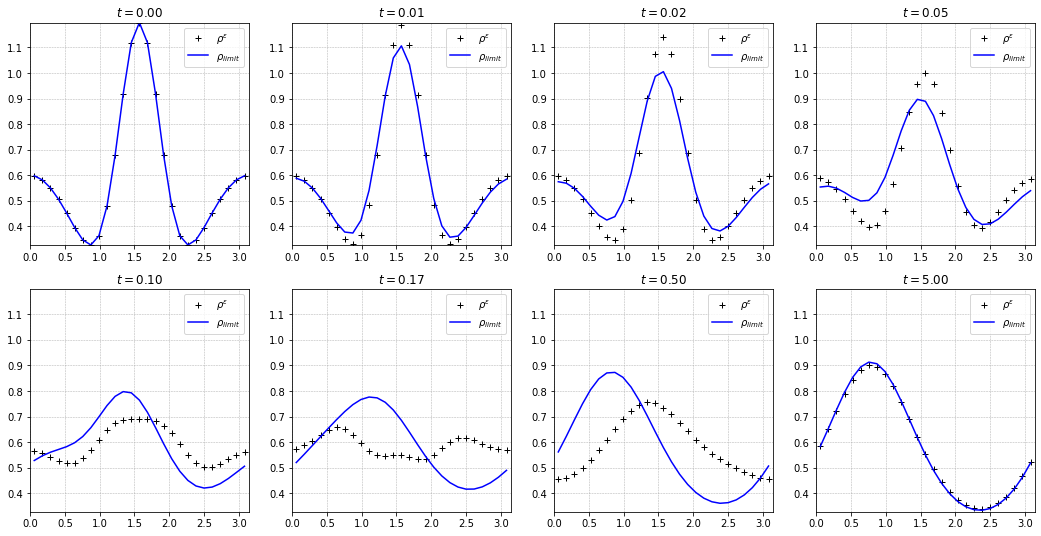

In [16]:
plt.rcParams['figure.figsize'] = 18, 9
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
rho_max = np.max(rho_)
rho_min = np.min(rho_)
for i in range(2):
    for j in range(4):
        index = i + j*2
        ax = plt.subplot(2,4,1+i + j*2)
        plt.plot(x,rho_[time_indices[index]], 'k+', label=r'$\rho^\varepsilon$')
        plt.plot(x,fluid_[time_indices[index]], 'b-', label=r'$\rho_{limit}$')
        plt.title(r'$t = '+('%.2f' % t[time_indices[index]])+'$')
        plt.ylim(rho_min, rho_max)
        plt.xlim(0, xstar)
        plt.grid(linestyle='--', linewidth=0.5)
        plt.legend()
plt.show()

### Coupling indicators

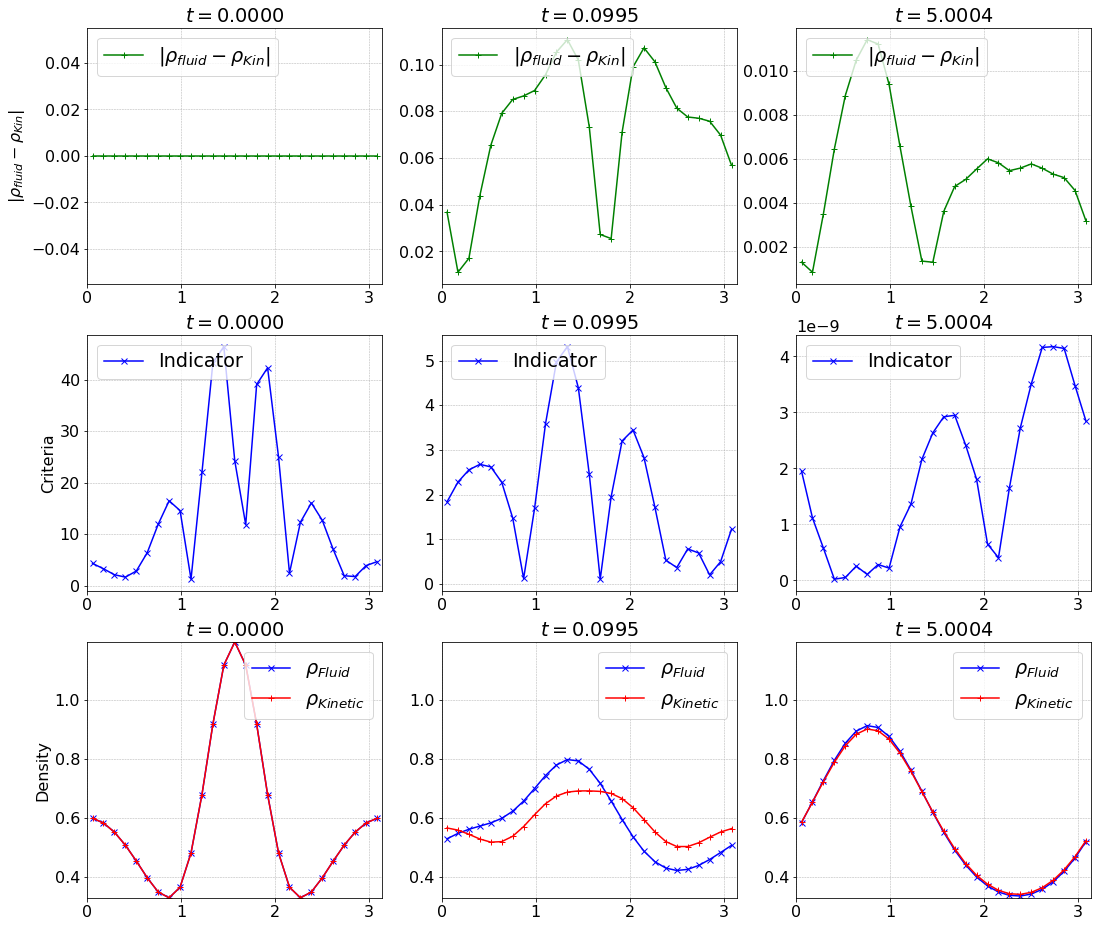

In [17]:
plt.rcParams['figure.figsize'] = 18, 16
plt.rcParams.update({'font.size': 16})
eta = 5
time_indices = [0, len(t)//50, len(t)-1]
lines = 3
cols  = 3
index = 0

i = 0
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel(r'$|\rho_{fluid}-\rho_{Kin}|$')
    diff=np.abs(fluid_[time_indices[index]]-rho_[time_indices[index]])
    plt.plot(x,diff, 'g-+', label=r'$|\rho_{fluid}-\rho_{Kin}|$')
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large', loc=2)
    index +=1
    
i = 1
index = 0
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel('Criteria')
    criteria = np.abs(indFluid_[time_indices[index]])
    plt.plot(x,criteria, 'b-x', label='Indicator')  
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large', loc=2)
    index +=1

i = 2
index = 0
rho_max = np.max(rho_)
rho_min = np.min(rho_)
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel('Density')
    plt.plot(x,fluid_[time_indices[index]], 'bx-', label=r'$\rho_{Fluid}$')
    plt.plot(x,rho_[time_indices[index]], 'r+-', label=r'$\rho_{Kinetic}$')
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
    plt.ylim(rho_min, rho_max)
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large')
    index +=1
plt.show()
plt.rcParams.update({'font.size': 10})

## Dynamic coupling

### Higher order model
To derive a coupling criterion on wether to consider the kinetic or the fluid model, we are interested an higher order model. We now consider the Chapmann-Enskog expansion up to 3rd order. Indeed, order 2 gives no further information. As $\varepsilon\longrightarrow 0$ the higher order fluid limit is given by


$$\partial_t\rho-\partial_x\left(H + \varepsilon^2(-\partial_{xx} H-E\partial_x H+2\partial_x(EH)) \right)=0$$
where  $H=(\partial_x\rho-E\rho)$
The difference with the diffusive limit presented before leads us to use the quantity $|-\partial_{xx} H-E\partial_x H+2\partial_x(EH)|$ as our coupling criterion.

In [19]:
# Knudsen number
epsilon = 0.6

# Time step and final time
C = 0.01
(dt,dtLim,dtFV) = CFL(np.max(dx),np.max(dv),m2,np.max(E),vstar,epsilon,C)
T = 4
# Enables dynamic coupling
Coupling = True
# Coupling = False
# Coupling criterion
eta   = 1e-2 # A bigger value makes it easier for cells to become fluid
delta = 1e-2 # Same here

print('|---------------------------------------------------------')
print('| Time steps :')
print('| FV    : ', dtFV)
print('| Limit : ', dtLim)
print('| Used  : ', dt)
print('| Final time  : ', T)
print('|------------------')
print('| Coupling :', Coupling)
if Coupling :
    print('| delta0 : ', delta)
    print('| eta0   : ', eta)
print('|------------------')

order = 2

i = 0
t = [0]
inveps = 1.0 / epsilon
# Initialize unknows
(Fn_c, rho_c, H_c, dxH_c, dvM) = Init(F, rho, E, invdx, DV, invDV, MM, m2)

# Save for comparisons
mass_c = [np.sum(rho_c*dx)]
F_c_   = [Fn_c.copy()]
rho_c_ = [rho_c.copy()]

Fn     = F
rho    = rho_c
mass_  = [np.sum(rho*dx)]
F_     = [Fn.copy()]
rho_   = [rho.copy()]

#Initialize the system with full information i.e. the kinetic model
isKinetic = np.full(Nx, True, dtype=bool) # True = kinetic, False = fluid

AllKin = isKinetic
AllFluid  = np.full(Nx, False, dtype=bool)

# A single kinetic region with ghost cells
reg = [i for i in range(-2,Nx)]
reg.extend([0,1])
regions = [reg]

Oneregion = regions

isKinetic_ = [isKinetic.copy()]
regions_   = [regions]

(indicator, indFluid) = indicators(rho, fluid, E[0,:], dxE[0,:], invdx)
indicator_ = [indicator.copy()]
L1G_ = [(np.sum(np.abs(G0*DV),axis=0)).copy()]

indKinetic_, indFluid_ = [indicator], [indFluid]

start= time.time()
while t[-1] < T:
    # Update f
    (Fn_c, rho_c, H_c, dxH_c, indicator, isKinetic,regions) = solve_Coupled(rho_c, Fn_c, E, dxE, H_c, dxH_c, 
                                                                isKinetic, regions, eta, delta, MM, invDX, V, DV,
                                                                invDV, dt, m2, m4, epsilon, inveps, Coupling, order, i)
    
    Fn = solve_Kinetic(Fn, E, MM, invDX, V, DV, invDV, dt, m2, inveps)
    
    fluid = solve_Fluid(fluid, E[0,:], m2, invdx, dt)
    
    # Dynamic time-step
#     if (isKinetic==AllFluid).all():
#         dt = dtLim
#     else:
#         dt = dtFV
    
    # Save unknowns
    t.append(t[-1] + dt)
    
    F_c_.append(Fn_c.copy())
    rho_c_.append(rho_c.copy())
    mass_c.append(np.sum(rho_c*dx))
    isKinetic_.append(isKinetic.copy())
    
    # Save for comparison
    F_.append(Fn.copy())
    rho_.append(np.sum(Fn*DV,axis=0).copy())
    mass_.append(np.sum(rho*dx))
    fluid_.append(fluid.copy())
    
    # Increment
    i = i + 1
stop = time.time()

m, s = divmod(stop-start, 60)
h, m = divmod(m, 60)
print("| Elapsed time: "+'{:f}:{:02f}:{:02f}'.format(h, m, s))
print('|---------------------------------------------------------')

|---------------------------------------------------------
| Time steps :
| FV    :  8.726646259971648e-05
| Limit :  0.0002707710398104265
| Used  :  8.726646259971648e-05
| Final time  :  4
|------------------
| Coupling : True
| delta0 :  0.01
| eta0   :  0.01
|------------------
| Elapsed time: 0.000000:0.000000:31.300502
|---------------------------------------------------------


### Snapshots of the distribution

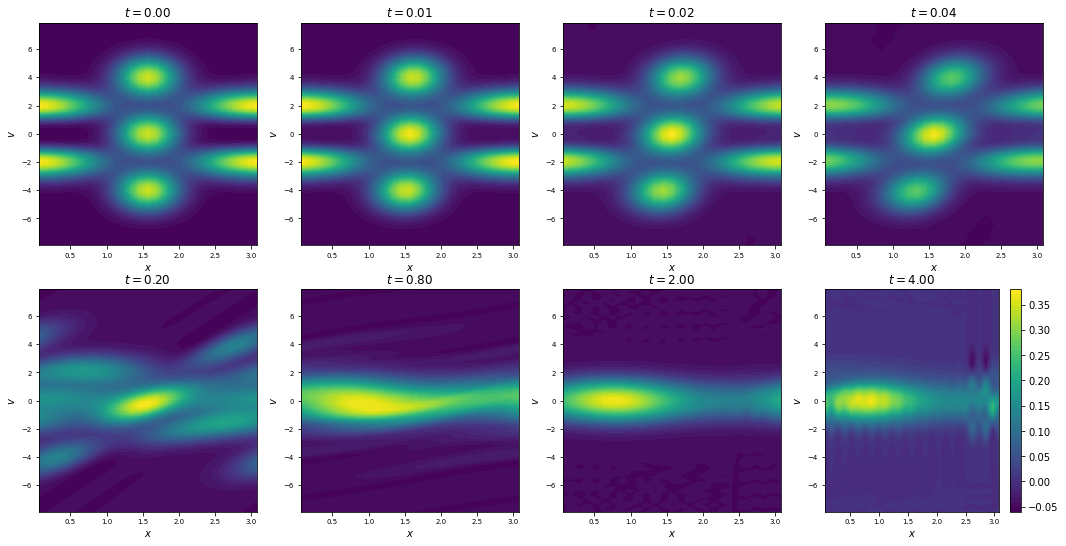

In [20]:
Nt = len(t)
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//20, len(t)//5, len(t)//2, len(t)-1]
plt.rcParams['figure.figsize'] = 18, 9
for i in range(2):
    for j in range(4):
        index = i + j*2
        plt.subplot(2,4,1+i + j*2)
        plt.contourf(X,V,F_c_[time_indices[index]], 50, cmap=plt.cm.viridis)
        plt.title(r'$t = $'+('%.2f' % t[time_indices[index]]))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$v$')
        plt.tick_params(axis='both', which='major', labelsize=7)
plt.colorbar()
plt.show()

### Snapshots of the densities

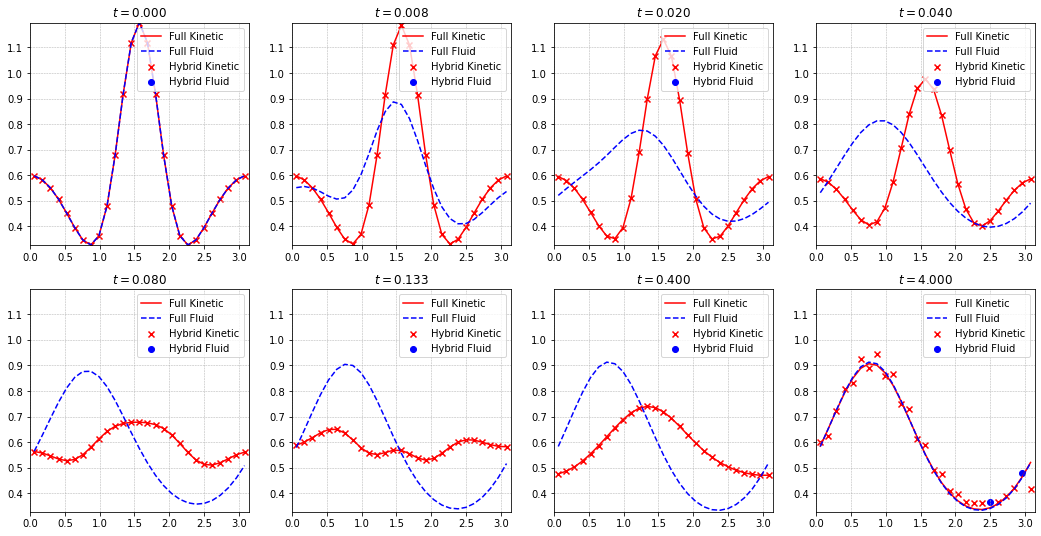

In [21]:
plt.rcParams['figure.figsize'] = 18, 9
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
rho_max = np.max(rho_)
rho_min = np.min(rho_)
for i in range(2):
    for j in range(4):
        index = i + j*2
        date = time_indices[index]
        ax = plt.subplot(2,4,1+i + j*2)
        plt.plot(x,rho_[date], 'r-', label=r'Full Kinetic')
        plt.plot(x,fluid_[date], 'b--', label=r'Full Fluid')
        plt.scatter(x[isKinetic_[date]],  rho_c_[date][isKinetic_[date]],  marker='x', c='r', zorder=-1, label=r'Hybrid Kinetic')
        plt.scatter(x[~isKinetic_[date]], rho_c_[date][~isKinetic_[date]], marker='o', c='b', label=r'Hybrid Fluid')
        plt.title(r'$t = '+('%.3f' % t[time_indices[index]])+'$')
        plt.ylim(rho_min, rho_max)
        plt.xlim(0, xstar)
        plt.grid(linestyle='--', linewidth=0.5)
        plt.legend()
plt.show()

### State of the cells and mass variation

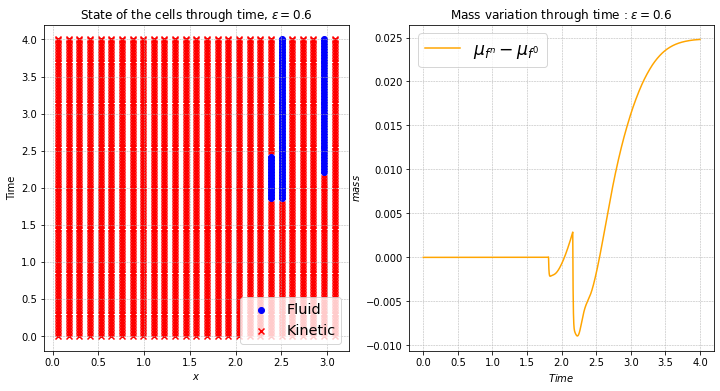

In [22]:
step = len(t)//101
date = t[0]
plt.rcParams['figure.figsize'] = 12, 6
plt.subplot(1,2,1)
plt.scatter(x[~isKinetic_[0]], np.ones(Nx)[~isKinetic_[0]]*date, marker='o', c='b', label='Fluid' if date==0 else '')
plt.scatter(x[isKinetic_[0]],  np.ones(Nx)[isKinetic_[0]]*date,  marker='x', c='r', label='Kinetic'if date==0 else '')
i = 1
for date in t[step::step]:
    plt.scatter(x[~isKinetic_[i]], np.ones(Nx)[~isKinetic_[i]]*date, marker='o', c='b')
    plt.scatter(x[isKinetic_[i]],  np.ones(Nx)[isKinetic_[i]]*date,  marker='x', c='r', zorder=-1)
    i = i+ step
plt.scatter(x[~isKinetic_[-1]], np.ones(Nx)[~isKinetic_[-1]]*t[-1], marker='o', c='b')
plt.scatter(x[isKinetic_[-1]],  np.ones(Nx)[isKinetic_[-1]]*t[-1],  marker='x', c='r', zorder=-1)
    
plt.title('State of the cells through time, '+r'$\varepsilon=$'+str(epsilon))
plt.xlabel(r'$x$')
plt.ylabel('Time')
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize='x-large', loc='lower right')

plt.subplot(1,2,2)
plt.plot(t,mass_c-mass_[0],c='orange',label=r'$\mu_{f^n} - \mu_{f^0}$')
plt.grid(linestyle='--', linewidth=0.5)
plt.title('Mass variation through time : '+r'$\varepsilon=$'+str(epsilon))
plt.legend(fontsize='xx-large')
plt.xlabel(r'$Time$')
plt.ylabel(r'$mass$')

plt.show()

# Convergence analysis

In [23]:
# # Available values of epsilon :
# # 1.0, 0.7, 0.5, 0.3, 0.1, 0.01
# epsilon = 0.01
# print('With projection onto the coarser grid:')
# Conv_analysis_Efield(epsilon)
# print('With lifting to the finer grid:')
# Conv_analysis_EfieldBis(epsilon)